# Scanning the BP dataset with pysegy

This notebook demonstrates how to download the BP 1994 2-D seismic dataset, scan it using the `pysegy` utilities and then visualise the source and receiver positions as well as a few shot gathers.

In [1]:
import sys
sys.path.append('..')  # allow importing the local pysegy package
import pysegy
import urllib.request, gzip, os, shutil
import numpy as np
import matplotlib.pyplot as plt


In [2]:
bp_url = 'http://s3.amazonaws.com/open.source.geoscience/open_data/bpstatics94/7m_shots_0601_0869.segy.gz'
local_gz = '7m_shots_0601_0869.segy.gz'
local_segy = '7m_shots_0601_0869.segy'

if not os.path.exists(local_segy):
    print('Downloading BP dataset...')
    with urllib.request.urlopen(bp_url) as resp, open(local_gz, 'wb') as f:
        shutil.copyfileobj(resp, f)
    with gzip.open(local_gz, 'rb') as gz, open(local_segy, 'wb') as out:
        shutil.copyfileobj(gz, out)


In [3]:

# Scan the SEGY file to find shot locations and offsets
scan = pysegy.segy_scan(local_segy)
shots = np.array(scan.shots)
offsets = np.array(scan.offsets)
counts = np.array(scan.counts)
fh = scan.fileheader
print(f'Total shots: {len(shots)}')
print('Samples per trace:', fh.bfh.ns)


Total shots: 135
Samples per trace: 1152


In [10]:
# Display human-readable headers
fh

BinaryFileHeader:
    Job                           :         0
    Line                          :         0
    Reel                          :         1
    DataTracePerEnsemble          :      3008
    AuxiliaryTracePerEnsemble     :         0
    dt                            :      5400
    dtOrig                        :         0
    ns                            :      1152
    nsOrig                        :         0
    DataSampleFormat              :         1
    EnsembleFold                  :         0
    TraceSorting                  :         0
    VerticalSumCode               :         0
    SweepFrequencyStart           :         0
    SweepFrequencyEnd             :         0
    SweepLength                   :         0
    SweepType                     :         0
    SweepChannel                  :         0
    SweepTaperlengthStart         :         0
    SweepTaperLengthEnd           :         0
    TaperType                     :         0
    CorrelatedDa

In [9]:
example_hdr = scan.read_headers(0, keys=['SourceX', 'GroupX', 'ns', "dt", "SourceDepth"])[0]
example_hdr

BinaryTraceHeader:
    SourceX                       :     12500
    GroupX                        :      5000
    ns                            :      1152
    dt                            :      5400
    SourceDepth                   :      6250

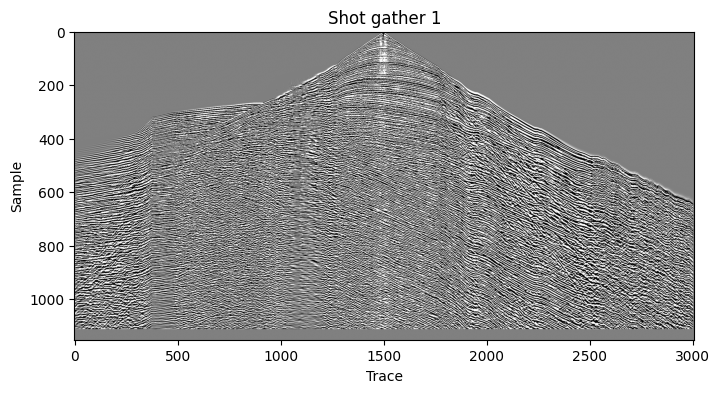

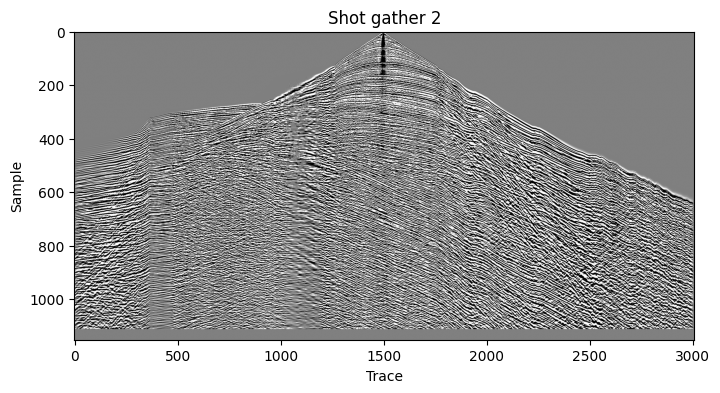

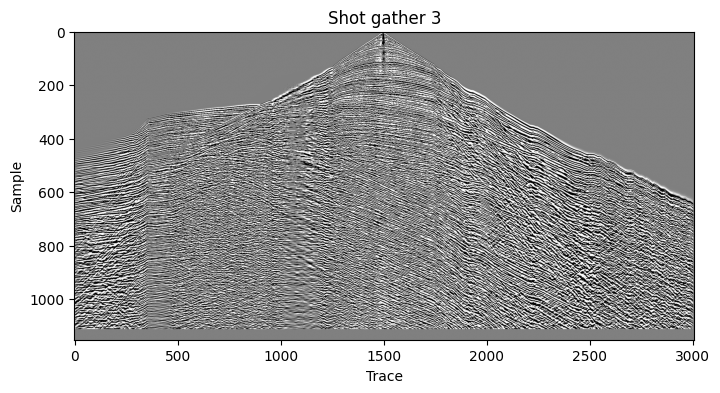

In [5]:

# Plot a few shot gathers using the lazy reader
for i in range(3):
    block = scan.read_shot(i)
    data = np.array(block.data, dtype=np.float32)
    plt.figure(figsize=(8,4))
    plt.imshow(data, aspect='auto', cmap='gray', vmin=-.0001, vmax=.0001)
    plt.title(f'Shot gather {i+1}')
    plt.xlabel('Trace')
    plt.ylabel('Sample')
    plt.show()


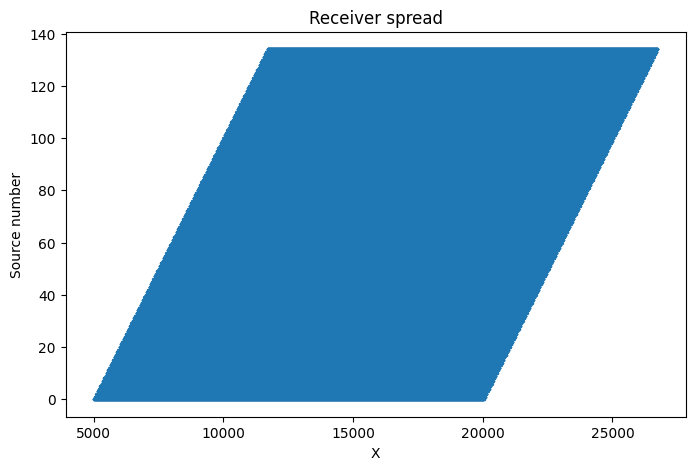

In [6]:

# Receiver spread across all sources
xvals = []
src_ids = []
for i in range(len(scan)):
    hdrs = scan.read_headers(i, keys=['GroupX'])
    xvals.extend(h.GroupX for h in hdrs)
    src_ids.extend([i] * len(hdrs))
plt.figure(figsize=(8,5))
plt.scatter(xvals, src_ids, s=2)
plt.xlabel('X')
plt.ylabel('Source number')
plt.title('Receiver spread')
plt.show()
